# Implementation Details

1. Creating the eight sets of emotions based on Plutchik's Wheel.
2. Importing the tweets to be analyzed.
3. Applying sentiment analysis to the tweets and arranging the resulting data in a dataframe.

## *The creation of the eight emotion sets of Plutchik's Wheel*

*Using an English-English dictionary containing numerous words with their explanations, the eight emotion sets of Plutchik's Wheel were generated. The primary emotions of Plutchik's Wheel are joy, trust, fear, surprise, sadness, disgust, anger, and anticipation.*

*Initially, dictionaries were formed for each emotion, where words were used as 'keys' and their number as 'values'. The words found within the explanation of each emotion were included in their respective dictionary, along with their numbers. Following that, the dictionaries were expanded by adding the words found within the explanations of each 'key'. The repetition of this process is controllable by the depth of the set function. In the event of encountering duplicate words, the 'value' will be incremented based on their number.*

*Eventually, the dictionaries for each emotion were saved as separate JSON files for future usage.*

In [49]:
# Import the modules required
import pandas as pd
import json
import operator
import requests
import regex as re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from string import digits
pd.options.display.max_colwidth = 280
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Reading the dictionary that will be used  to create the sets
data = json.load(open(r"thesaurus.json"))

In [51]:
# Set a function taking out related words for a given word and putting them all into a dictionary

def find_related(input_string: str, dictionary: dict, depth: int = 1):
    if input_string not in dictionary:
        return
# I used 'source and target' since we can't make changes in the dictionary in Python while traversing over it
    source = {input_string: 1}
    target = {}

    for i in range(depth):
        for word1 in source:
            if word1 not in dictionary:
                continue

            # Find the related words
            description = dictionary[word1]
        
            for word in description:

                # Build dictionary from list
                if word not in target:
                    target[word] = 1
                else:
                    target[word] += 1

        source.clear()
        source = target.copy()

    return target

In [52]:
# Set a function sorting the emotion dictionaries in descending order, and adjusting their lengths to make them equivalent

def limit_of_set (emotion, depth, limit):
    
    set = find_related(emotion, data, depth)
    print('The length of', emotion, 'dictionary: ', len(set))
    
    # Sort the dictionary in a descending order based on its values.
    order_set = dict( sorted(set.items(), key=operator.itemgetter(1), reverse=True))
    
    # Trim the dictionary at a specific point
    emotion_set = {}
    for key, value in order_set.items():
        if len(emotion_set) > limit:
            break
        emotion_set[key] = value
    print('The length of', emotion, 'dictionary after cutting: ', len(emotion_set))
    
    # Equalize the dictionary values after cutting
    emotion_set = dict.fromkeys(emotion_set, 1)
        
    return emotion_set

***Call the function for all emotions***

In [53]:
joy = limit_of_set('joy', 3, 100)
# Store the dictionary in a json file
with open('sets\\joy.json', 'w') as fp:
    json.dump(joy, fp)

trust = limit_of_set('trust', 3, 100)
with open('sets\\trust.json', 'w') as fp:
    json.dump(trust, fp)

fear = limit_of_set('fear', 4, 100)
with open('sets\\fear.json', 'w') as fp:
    json.dump(fear, fp)

surprise = limit_of_set('surprise', 4, 100)
with open('sets\\surprise.json', 'w') as fp:
    json.dump(surprise, fp)

sadness = limit_of_set('sadness', 3, 100)
with open('sets\\sadness.json', 'w') as fp:
    json.dump(sadness, fp)

disgust = limit_of_set('disgust', 4, 100)
with open('sets\\disgust.json', 'w') as fp:
    json.dump(disgust, fp)

anger = limit_of_set('anger', 3, 100)
with open('sets\\anger.json', 'w') as fp:
    json.dump(anger, fp)

anticipation = limit_of_set('anticipation', 4, 100)
with open('sets\\anticipation.json', 'w') as fp:
    json.dump(anticipation, fp)

The length of joy dictionary:  129
The length of joy dictionary after cutting:  101
The length of trust dictionary:  253
The length of trust dictionary after cutting:  101
The length of fear dictionary:  157
The length of fear dictionary after cutting:  101
The length of surprise dictionary:  164
The length of surprise dictionary after cutting:  101
The length of sadness dictionary:  127
The length of sadness dictionary after cutting:  101
The length of disgust dictionary:  206
The length of disgust dictionary after cutting:  101
The length of anger dictionary:  169
The length of anger dictionary after cutting:  101
The length of anticipation dictionary:  101
The length of anticipation dictionary after cutting:  101


In [54]:
# Print some keys of Joy dictionary.
dict(list(joy.items())[:10])

{'transport': 1,
 'ecstasy': 1,
 'rapture': 1,
 'delight': 1,
 'enjoyment': 1,
 'joy': 1,
 'pleasure': 1,
 'happiness': 1,
 'bliss': 1,
 'gladness': 1}

## *The application of sentiment analysis*

***Set a class applying Sentiment Analysis to Tweets by detecting intersections between each Tweet and emotion dictionaries***

In [55]:
class Feeling:
    # Import the dictionaries into the class.
    joy_dic = json.load(open(f"sets\\joy.json"))
    trust_dic = json.load(open(f"sets\\trust.json"))
    fear_dic = json.load(open(f"sets\\fear.json"))
    surprise_dic = json.load(open(f"sets\\surprise.json"))
    sadness_dic = json.load(open(f"sets\\sadness.json"))
    disgust_dic = json.load(open(f"sets\\disgust.json"))
    anger_dic = json.load(open(f"sets\\anger.json"))
    anticipation_dic = json.load(open(f"sets\\anticipation.json"))
    
    def __init__(self, tweet):
        # Assign an initial value to each emotion in each tweet.
        self.joy = 0
        self.trust = 0
        self.fear = 0
        self.surprise = 0
        self.sadness = 0
        self.disgust = 0
        self.anger = 0
        self.anticipation = 0
        self.tot = 0

        self.words = []
        self.split(tweet)
        self.find_frequency()

    def split(self, tweet):
        # Clean the tweets
        res = ''.join([i for i in tweet if not i.isdigit()])
        self.words = re.sub(r'[^\w\s]', '', res.lower()).split()
        for word in self.words:
            if word in stopwords.words('english'):
                self.words.remove(word)
                continue

    def find_frequency(self):
        # Compute the intersections between every tweet and each set of emotion sets.
        for word in self.words:
            self.joy += Feeling.joy_dic.get(word, 0)
            self.trust += Feeling.trust_dic.get(word, 0)
            self.fear += Feeling.fear_dic.get(word, 0)
            self.surprise += Feeling.surprise_dic.get(word, 0)
            self.sadness += Feeling.sadness_dic.get(word, 0)
            self.disgust += Feeling.disgust_dic.get(word, 0)
            self.anger += Feeling.anger_dic.get(word, 0)
            self.anticipation += Feeling.anticipation_dic.get(word, 0)
            self.tot = self.joy+self.trust+self.fear+self.surprise+self.sadness+self.disgust+self.anger+self.anticipation
            
        # Normalize the outcomes
        try:
            self.joy /= self.tot
            self.trust /= self.tot
            self.fear /= self.tot
            self.surprise /= self.tot
            self.sadness /= self.tot
            self.disgust /= self.tot
            self.anger /= self.tot
            self.anticipation /= self.tot
        except:
            pass

## *The importing of tweets to be analyzed*

***Now, import 30000 Tweets related to World Cup 2022 Using Snscrape Libray***

In [8]:
import snscrape.modules.twitter as sntwitter

# Creating list to append tweet data to
tweets_list = []

query = 'world cup 2022 lang:en since:2022-11-20 until:2022-12-20'
limit = 30000

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
    if i > limit:
        break
    tweets_list.append([tweet.username, tweet.date, tweet.content])
    
# Creating a dataframe to load the list
tweets_df = pd.DataFrame(tweets_list, columns=["User", "Date", "Tweet"])
tweets_df.to_csv('world_cup.csv')

Unavailable user in card on tweet 1604971095655841798
Unavailable user in card on tweet 1604971095655841798
User 26734856 not found in user refs in card on tweet 1604971095655841798
User 26734856 not found in user refs in card on tweet 1604971095655841798
Unavailable user in card on tweet 1604940393753284608
User 1041604336160137216 not found in user refs in card on tweet 1604940393753284608
Unavailable user in card on tweet 1604928056162152448
Unavailable user in card on tweet 1604928056162152448
User 363577315 not found in user refs in card on tweet 1604928056162152448
User 363577315 not found in user refs in card on tweet 1604928056162152448
Unavailable user in card on tweet 1604923780152692736
User 1041604336160137216 not found in user refs in card on tweet 1604923780152692736
Unavailable user in card on tweet 1604910190528266250
User 1041604336160137216 not found in user refs in card on tweet 1604910190528266250
Unavailable user in card on tweet 1604902214417453071
User 280672679 

Unavailable user in card on tweet 1604730094949392384
User 838824624200769537 not found in user refs in card on tweet 1604730094949392384
Unavailable user in card on tweet 1604727993351503873
User 497688906 not found in user refs in card on tweet 1604727993351503873
Unavailable user in card on tweet 1604727134324330496
User 363577315 not found in user refs in card on tweet 1604727134324330496
Unavailable user in card on tweet 1604725523476725760
User 363577315 not found in user refs in card on tweet 1604725523476725760
Unavailable user in card on tweet 1604723779795668992
Unavailable user in card on tweet 1604723779795668992
User 1239949343873998854 not found in user refs in card on tweet 1604723779795668992
User 1239949343873998854 not found in user refs in card on tweet 1604723779795668992
Unavailable user in card on tweet 1604708382853799942
Unavailable user in card on tweet 1604708382853799942
User 1239949343873998854 not found in user refs in card on tweet 1604708382853799942
User

In [56]:
tweets_df = pd.read_csv('world_cup.csv')
tweets_df

,Unnamed: 0,User,Date,Tweet
0,0,MessiGoatesque,2022-12-19 23:59:53+00:00,"MessiStats_: 03.12.2022\nWorld Cup Round of 16\nArgentina vs Australia 2-1\n\nMessi marked his 1,000th senior career game with his first goal in the knockout stage of a World Cup in a victory over Australia.\n\nIt was also Messi's 100th game as a starting capt… https://t.co/h..."
1,1,MessiGoatesque,2022-12-19 23:59:52+00:00,"MessiStats_: 30.11.2022\nWorld Cup group stage\nPoland vs Argentina 0-2\n\nMessi missed a penalty on his record-breaking 22nd World Cup match, one more than the late Diego Maradona managed for La Albiceleste.\n\nIt is the only match of the 2022 World Cup witho… https://t.co/I..."
2,2,MessiGoatesque,2022-12-19 23:59:51+00:00,"MessiStats_: Against Mexico, Messi lifted his goal tally for Argentina in 2022 to 13, more than in any other calendar year. His previous record was 12 goals from 2021.\n\nHe also registered his first assist of the 2022 World Cup by setting up Enzo Fernande… https://t.co/YC8Xx..."
3,3,MessiGoatesque,2022-12-19 23:59:50+00:00,"MessiStats_: 26.11.2022\nWorld Cup, group stage\nArgentina vs Mexico 2-0\n\nMessi produced a moment of trademark magic to help keep Argentina's World Cup hopes alive in a much needed victory.\n\nIt was an eighth World Cup goal for Messi, who played his 21st Wo… https://t.co/u..."
4,4,MessiGoatesque,2022-12-19 23:59:49+00:00,"MessiStats_: 26.11.2022\nWorld Cup, group stage\nArgentina vs Mexico 2-0\n\nMessi produced a moment of trademark magic to help keep Argentina's World Cup hopes alive in a much needed victory.\n\nIt was an eighth World Cup goal for Messi, who played his 21st Wo… https://t.co/L..."
...,...,...,...,...
29996,29996,walexybig,2022-12-18 20:24:11+00:00,@afalli Nigeria to win this world cup
29997,29997,XabierFrancois,2022-12-18 20:24:11+00:00,@IrishPropaganda Irish descendant Alexis MacAllister wins the WORLD Cup in the most terrifying electric final in the history of world sport
29998,29998,realsimileoluwa,2022-12-18 20:24:10+00:00,"Like Messi, you can see him showing common sense of not joining the next World Cup due to age. \n\nAlso, he has won and achieved so much yet, he’s doing right by nature. \n\nI beg you in the name of whoever you serve, step down and enjoy.\n\nDaddy, REST."
29999,29999,KaljPre,2022-12-18 20:24:10+00:00,@mags324 Thanks Maggie. Yes had a good day ☺. Was watching world cup final. Thrilling match 👍😊. Hope you're having a lovely evening.


### *Run the class and arrange the results in a DataFrame.*

In [57]:
# Create empty DataFrame with column names
df = pd.DataFrame(columns = ['Tweet', 'Joy', 'Trust', 'Fear', 'Surprise',
                             'Sadness', 'Disgust', 'Anger', 'Anticipation'])

# Fill the DataFrame with the result of each tweet row by row
for twt in tweets_df['Tweet']:
    tweet = Feeling(twt)
    df.loc[len(df)] = [twt, tweet.joy, tweet.trust, tweet.fear, tweet.surprise,
                       tweet.sadness, tweet.disgust, tweet.anger, tweet.anticipation]

# Add a row containing the mean of each emotion for all Tweets
df = df.set_index('Tweet')
df.loc['mean'] = df.mean()
df

,Joy,Trust,Fear,Surprise,Sadness,Disgust,Anger,Anticipation
Tweet,,,,,,,,
"MessiStats_: 03.12.2022\nWorld Cup Round of 16\nArgentina vs Australia 2-1\n\nMessi marked his 1,000th senior career game with his first goal in the knockout stage of a World Cup in a victory over Australia.\n\nIt was also Messi's 100th game as a starting capt… https://t.co/hshCBva5Y5",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
"MessiStats_: 30.11.2022\nWorld Cup group stage\nPoland vs Argentina 0-2\n\nMessi missed a penalty on his record-breaking 22nd World Cup match, one more than the late Diego Maradona managed for La Albiceleste.\n\nIt is the only match of the 2022 World Cup witho… https://t.co/IDiVKdFS5A",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
"MessiStats_: Against Mexico, Messi lifted his goal tally for Argentina in 2022 to 13, more than in any other calendar year. His previous record was 12 goals from 2021.\n\nHe also registered his first assist of the 2022 World Cup by setting up Enzo Fernande… https://t.co/YC8XxX3Uzi",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
"MessiStats_: 26.11.2022\nWorld Cup, group stage\nArgentina vs Mexico 2-0\n\nMessi produced a moment of trademark magic to help keep Argentina's World Cup hopes alive in a much needed victory.\n\nIt was an eighth World Cup goal for Messi, who played his 21st Wo… https://t.co/uHYeIVp4oe",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
"MessiStats_: 26.11.2022\nWorld Cup, group stage\nArgentina vs Mexico 2-0\n\nMessi produced a moment of trademark magic to help keep Argentina's World Cup hopes alive in a much needed victory.\n\nIt was an eighth World Cup goal for Messi, who played his 21st Wo… https://t.co/LUAE0smwAN",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...
@IrishPropaganda Irish descendant Alexis MacAllister wins the WORLD Cup in the most terrifying electric final in the history of world sport,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
"Like Messi, you can see him showing common sense of not joining the next World Cup due to age. \n\nAlso, he has won and achieved so much yet, he’s doing right by nature. \n\nI beg you in the name of whoever you serve, step down and enjoy.\n\nDaddy, REST.",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
@mags324 Thanks Maggie. Yes had a good day ☺. Was watching world cup final. Thrilling match 👍😊. Hope you're having a lovely evening.,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.50000


<AxesSubplot:title={'center':'The emotional distribution surrounding the World Cup 2022 based on 30000 tweets'}>

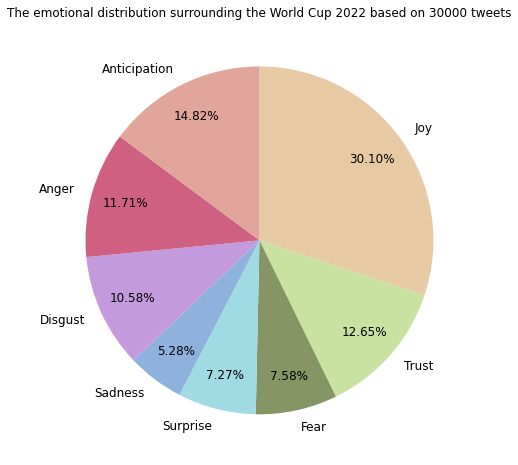

In [60]:
# Visualize the results in a pie chart
colors = ['#E7CAA3','#C9E1A1','#869564','#A0DAE2','#8FB1DD','#C39ADD','#CF6081','#E2A59B']
df.iloc[len(df)-1].plot.pie(figsize=(8, 8),colors=colors, fontsize=12, autopct='%1.2f%%',
                                 startangle=90, counterclock=False, pctdistance=0.8, label="",
                                 title = 'The emotional distribution surrounding the World Cup 2022 based on 30000 tweets')

### *Let's test the model on another topic, COVID-19 pandemic for example*

In [12]:
tweets_list1 = []

query = 'covid lang:en since:2019-11-17 until:2020-02-17'
limit = 30000

for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
    if i > limit:
        break
    tweets_list1.append([tweet.username, tweet.date, tweet.content])
    
tweets_df1 = pd.DataFrame(tweets_list1, columns=["User", "Date", "Tweet"])
tweets_df1.to_csv('covid.csv')

Unavailable user in card on tweet 1229189826345345025
User 218852667 not found in user refs in card on tweet 1229189826345345025
Unavailable user in card on tweet 1229144418638336007
User 73275576 not found in user refs in card on tweet 1229144418638336007
Unavailable user in card on tweet 1229049768195829760
Unavailable user in card on tweet 1229049768195829760
User 15843059 not found in user refs in card on tweet 1229049768195829760
User 15843059 not found in user refs in card on tweet 1229049768195829760
Unavailable user in card on tweet 1229043251170041859
User 1236072169 not found in user refs in card on tweet 1229043251170041859
Unavailable user in card on tweet 1228895048525402112
Unavailable user in card on tweet 1228895048525402112
User 1630083736837521409 not found in user refs in card on tweet 1228895048525402112
User 1630083736837521409 not found in user refs in card on tweet 1228895048525402112
Unavailable user in card on tweet 1228872639806087168
User 218852667 not found 

In [61]:
tweets_df1 = pd.read_csv('covid.csv')
tweets_df1

,Unnamed: 0,User,Date,Tweet
0,0,Mariano38298612,2023-06-05 23:06:16+00:00,@gabicerru Mierda... y para cobrar eso hay que anotarse en algún lugar? O con tener 6 dosis de CoVID alcanza?
1,1,cidaqueiroz,2023-06-05 23:06:16+00:00,"O ex-ministro da saúde italiano, Roberto Speranza, mais conhecido como o Ministro da Morte, teve que fugir de um grupo de cidadãos, que queria linchá-lo porque perderam parentes devido aos protocolos assassinos do Covid.\n\nTinha que pegar um para servir de exemplo..."
2,2,Bowmore52,2023-06-05 23:06:15+00:00,"#DoNotComply with digital ID, CBDCs, vaccine passports or any other types of that shit because this is where we will end up. They started it during covid and the majority kowtowed and let fascism rule…. #daretothink #STANDUP\n\n@HouseofCommons Where do you stand ?"
3,3,TheSocialSage1,2023-06-05 23:06:15+00:00,Five things to know about macOS Sonoma https://t.co/9nTB7KGSkb #engineer #digital #covid #iot #photography
4,4,celticgem1776,2023-06-05 23:06:08+00:00,"@VapeTrainGaming @not_onions @laurenboebert #1, covid happened with all of the stimulus money. #2, Biden is on target to surpass that."
...,...,...,...,...
29996,29996,kabarpolitik,2020-02-13 15:35:45+00:00,WHO Targetkan Vaksin COVID-19 Bisa Digunakan 18 Bulan Lagi https://t.co/OByRqPDi0y
29997,29997,kabarpolitik,2020-02-13 15:35:44+00:00,Peneliti Tiongkok Kembangkan Sistem Deteksi Portabel Kasus Covid-19 https://t.co/d5zD0x6NoN
29998,29998,BNNBloomberg,2020-02-13 15:35:21+00:00,WATCH #LIVE: Ontario health officials provide an update on the province's response to the COVID-19 outbreak https://t.co/x5hveRlt3n https://t.co/klXaRrANHa
29999,29999,atonsan602,2020-02-13 15:35:14+00:00,@Sibyl096 COVID inc.表示\n北海道新冠市表示


In [65]:
# Create empty DataFrame with column names
df1 = pd.DataFrame(columns = ['Tweet', 'Joy', 'Trust', 'Fear', 'Surprise',
                             'Sadness', 'Disgust', 'Anger', 'Anticipation'])

# Fill the DataFrame with the result of each tweet row by row
for twt in tweets_df1['Tweet']:
    tweet = Feeling(twt)
    df1.loc[len(df1)] = [twt, tweet.joy, tweet.trust, tweet.fear, tweet.surprise,
                       tweet.sadness, tweet.disgust, tweet.anger, tweet.anticipation]

# Add a row containing the mean of each emotion for all Tweets
df1 = df1.set_index('Tweet')
df1.loc['mean'] = df1.mean()
df1

,Joy,Trust,Fear,Surprise,Sadness,Disgust,Anger,Anticipation
Tweet,,,,,,,,
@gabicerru Mierda... y para cobrar eso hay que anotarse en algún lugar? O con tener 6 dosis de CoVID alcanza?,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"O ex-ministro da saúde italiano, Roberto Speranza, mais conhecido como o Ministro da Morte, teve que fugir de um grupo de cidadãos, que queria linchá-lo porque perderam parentes devido aos protocolos assassinos do Covid.\n\nTinha que pegar um para servir de exemplo...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"#DoNotComply with digital ID, CBDCs, vaccine passports or any other types of that shit because this is where we will end up. They started it during covid and the majority kowtowed and let fascism rule…. #daretothink #STANDUP\n\n@HouseofCommons Where do you stand ?",1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Five things to know about macOS Sonoma https://t.co/9nTB7KGSkb #engineer #digital #covid #iot #photography,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"@VapeTrainGaming @not_onions @laurenboebert #1, covid happened with all of the stimulus money. #2, Biden is on target to surpass that.",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
Peneliti Tiongkok Kembangkan Sistem Deteksi Portabel Kasus Covid-19 https://t.co/d5zD0x6NoN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
WATCH #LIVE: Ontario health officials provide an update on the province's response to the COVID-19 outbreak https://t.co/x5hveRlt3n https://t.co/klXaRrANHa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
@Sibyl096 COVID inc.表示\n北海道新冠市表示,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:title={'center':'The emotional distribution surrounding COVID-19 pandemic based on 30000 tweets'}>

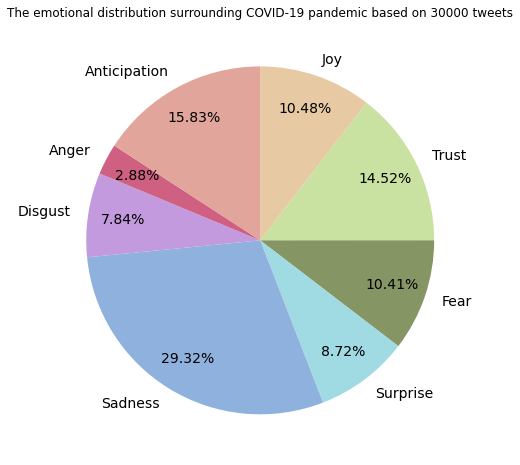

In [67]:
# Visualize the results in a pie chart
df1.iloc[len(df1)-1].plot.pie(figsize=(8, 8),colors=colors, fontsize=14, autopct='%1.2f%%',
                                   startangle=90, counterclock=False, pctdistance=0.8, label="",
                                   title = 'The emotional distribution surrounding COVID-19 pandemic based on 30000 tweets')